## LIME  
 https://www.dlology.com/blog/can-you-trust-keras-to-tell-african-from-asian-elephant/
### 1. Superpixel:
#### WHAT?
- A group of connected pixels with similar colors or gray levels.
- Divide an image into hundreds of non-overlapping superpixels. 

#### WHY?
- Compute features on more meaningful regions.
- Reduce the input entities for the subsequnt algorithms.

### 2. Predict by RandomForrest:
- The notebook shows how the lime_image tools can be applied to a smaller dataset like mnist. The dataset is very low resolution and allows quite a bit of rapid-iteration.

### Step1: Import lib and data: 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images
%matplotlib inline

In [3]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

c:\anaconda3\anaconda3_2\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
c:\anaconda3\anaconda3_2\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
# make each image color so lime_image works correctly
X_vec = np.stack([gray2rgb(iimg) for iimg in mnist.data.reshape((-1, 28, 28))],0)
y_vec = mnist.target.astype(np.uint8)

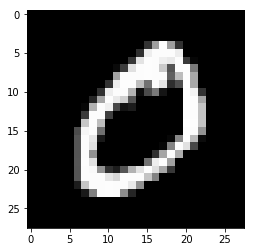

In [60]:
fig, ax1 = plt.subplots(1, 1)
ax1.imshow(X_vec[0], interpolation='none') # X_vec[5923]: image of 1

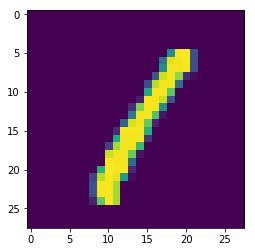

In [6]:
fig, ax1 = plt.subplots(1, 1)
ax1.imshow(mnist.data.reshape((-1, 28, 28))[5923], interpolation='none')

In [7]:
X_vec[5923,10]

array([[  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [155, 155, 155],
       [253, 253, 253],
       [253, 253, 253],
       [189, 189, 189],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0]], dtype=uint8)

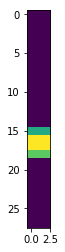

In [8]:
fig, ax1 = plt.subplots(1, 1)
ax1.imshow(X_vec[5923, 10], interpolation='none')

In [9]:
y_vec[5923]

1

- Display the lable and digit together:

Text(0.5,1,'Digit: 0')

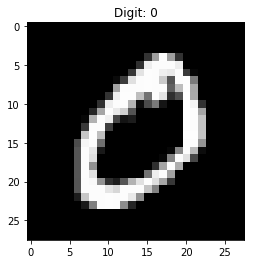

In [10]:
fig, ax1 = plt.subplots(1,1)
ax1.imshow(X_vec[0], interpolation='none')
ax1.set_title('Digit: {}'.format(y_vec[0]))

### Step2: Setup a Pipeline:
- Make a pipeline to process the images where flatten the image into 1-dimision vector and use RandomForrest classifier.

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier

In [12]:
class PipeStep(object):
    '''Wrapper for turning functions into pipeline transforms.'''
    def __init__(self, step_func):
        self._step_func = step_func
    def fit(self, *args):
        return self
    def transform(self, X):
        return self._step_func(X)

In [13]:
makegrey_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

In [14]:
type(makegrey_step)

__main__.PipeStep

__Pipeline:__
   - machine learning pipelines are cyclical and iterative as every step is repeated to continuously improve the accuracy of the model and achieve a successful algorithm.
   - To help automate machine learning workflows. 
   - Allows sticking multiple processes into a single scikit-learn estimator.
   - pipeline class has fit, predict and score method just like any other estimator

In [15]:
simple_rf_pipeline = Pipeline([('Make Gray', makegrey_step),
                               ('Flatten Image', flatten_step),
                               ('RF', RandomForestClassifier())])

### Step3: Data processing:

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec, test_size=0.55)

### Step4: Pipeline fitting on Train set:

In [18]:
simple_rf_pipeline.fit(X_train, y_train)

c:\anaconda3\anaconda3_2\envs\tensorflow\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('Make Gray', <__main__.PipeStep object at 0x0000021F6314ADA0>), ('Flatten Image', <__main__.PipeStep object at 0x0000021F6314AE80>), ('RF', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
      ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

### 3. LIME for interpretability:

### Step1: import LIME:
- %load_ext autoreload: Python extension to reload modules before executing user code.

In [19]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..','..')) # add the current directory
    import lime

### Step2: Initialize LIME explainer:

In [20]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer(verbose=False)

### Step3: Initialize Segmenter:

In [21]:
from lime.wrappers.scikit_image import SegmentationAlgorithm

segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

### Step4: Explain the X_test[0]:

- __%%time:__ works for cell which only contains 1 statement.
- <font color='red'>__explainer.explain_instance():__ Generates explanations for a prediction.</font>
    - In this function, firstly, generate neighborhood data by randomly perturbing features from instance. Then learn locally weighted linear models on  this neiborhood data to explain each of the classes in an interpretable way.
        - __data_row__: 1d numpay array, corresponding to a row  
        - __classifier_fn__: classifier prediction probablity function: take a np array and outputs prediction probabilities. (For ScikitClassifiers, this is  classifier_predict_proba.)  
        - __labels__: iterable with labesl to be explained.  
        - __top_labels__: Not none: produce explanations for the K labels with highest prediction probabilities.
        - __num_features__: max num of features present in explanation
        - __num_samples__: size of the neighborhood to learn the linear model

- __explanation.get_image_and_mask__:  
explanation.get_image_and_mask(label, positive_only=True, hide_rest=False, num_features=5,
min_weight=0.0)


Wall time: 2.15 s


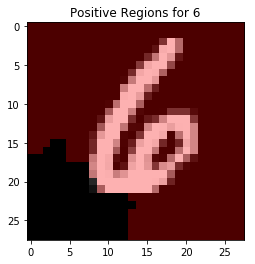

In [24]:
%%time
explanation  = explainer.explain_instance(X_test[0], classifier_fn=simple_rf_pipeline.predict_proba, top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=True, num_features=10, hide_rest=False, min_weight=0.01)

fig, ax1=plt.subplots(1, 1, figsize=(8,4))
ax1.imshow(label2rgb(mask, temp, bg_label=0), interpolation='nearest')

ax1.set_title('Positive Regions for {}'.format(y_test[0]))


Text(0.5,1,'Positive/Negative Regions for 6')

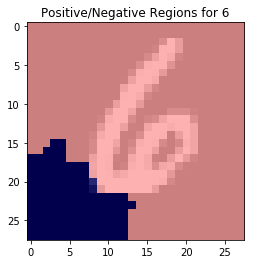

In [57]:
#explanation  = explainer.explain_instance(X_test[0], classifier_fn=simple_rf_pipeline.predict_proba, top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)
temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=False, num_features=10, hide_rest=False, min_weight=0.01)

fig, ax2 = plt.subplots(1, 1, figsize=(8,4))
ax2.imshow(label2rgb(3-mask, temp, bg_label=0), interpolation='nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test[0]))

### Step5: Show them for each class:


numpy.ndarray

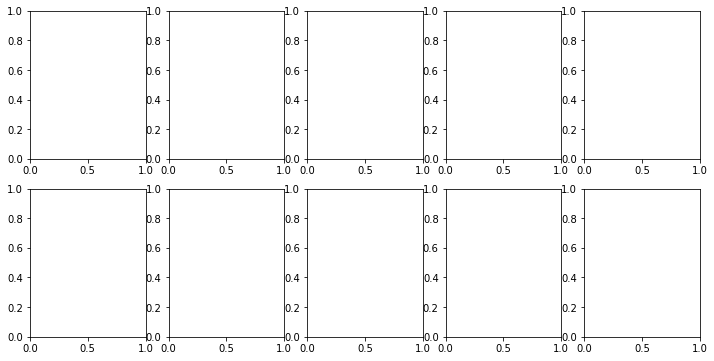

In [39]:
#fig, m_axs = plt.subplots(2, 5, figsize=(12,6))
#type(m_axs)

In [40]:
#"flatten" the array into 1D then loop over 1D array through 0 to 20.
# m_axs.flatten()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000021F01EADB38>,
      dtype=object)

- <font color='red'>get_image_and_mask(label, positive_only=True, hide_rest=False, num_features=5, min_weight=0.0):</font>
    - __label__: – label to explain
    - __positive_only__: -  
        - True: only take the superpixels that contribute to the prediction of label.
        - False: use top num_features superpixels (can be positive or negative towards the label)
    - __hide_rest__:
        - True: make the non-explanation part of the return image gray
    - __num_features__:
        - number of superpixels to include in explanation
    - __RETURN:__ (image, mask): 
        - image: a 3d numpy array
        - mask: 2d numpy array (can be used with skimage.segmentation.mark_boundaries)

m_axs: 
[[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021F02F1D828>
m_axs.flatten(): 

temp image 3d array: 
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]

mask 2d array: 
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]]

c_ax: 
AxesSubplot(0.125,0.536818;0.133621x0.343182)

temp image 3d array: 
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 

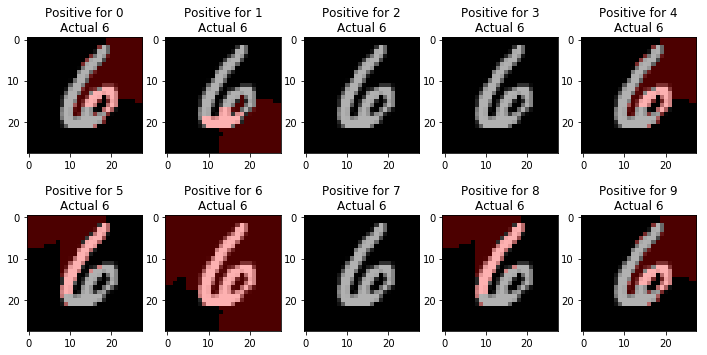

In [79]:
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
print('m_axs: \n{}'.format(m_axs))
print('m_axs.flatten(): \n{}'.format(m_axs.flatten()))

for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, hide_rest=True, min_weight=0.01)
    print('\ntemp image 3d array: \n{}'.format(temp[:1]))
    print('\nmask 2d array: \n{}'.format(mask[:1]))    
    print('\nc_ax: \n{}'.format(c_ax))
    
    # interpolation = 'none' works well when a big image is scaled down, while interpolation = 'nearest' works well when a small image is scaled up:
    # https://matplotlib.org/gallery/images_contours_and_fields/interpolation_methods.html
    c_ax.imshow(label2rgb(mask, X_test[0], bg_label=0), interpolation='nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test[0]))
    #c_ax.axis('off')

### Step5: Gaining Insight

#### Step5.1: Check the wrong classification:

- Can we find an explanation for a classification the algorithm got wrong?

In [98]:
pipe_pred_test = simple_rf_pipeline.predict(X_test)

# np.random.choice(): Generates a random sample from a given 1-D array
wrong_idx = np.random.choice(np.where(pipe_pred_test!=y_test)[0])

print('Using #{} where the label was {} and the pipeline predicted {}'.format(wrong_idx, y_test[wrong_idx], pipe_pred_test[wrong_idx]))

Using #15100 where the label was 3 and the pipeline predicted 5


#### Step5.2: Generate explainer:

<font color='red'>num_features will be 10 rathen than 1000 the one in the general explanation.</font>

Wall time: 2.25 s


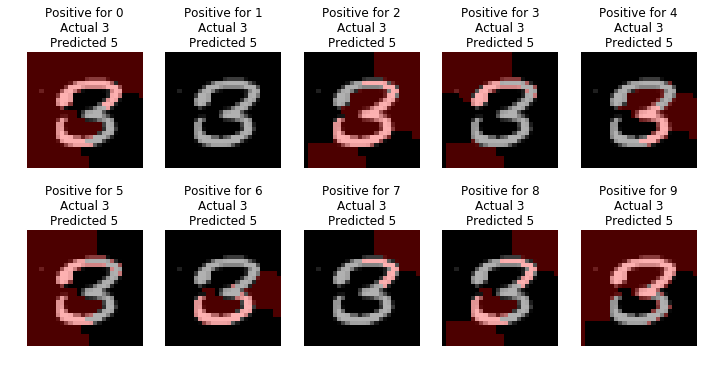

In [107]:
%%time
explanation_wrong = explainer.explain_instance(X_test[wrong_idx], classifier_fn=simple_rf_pipeline.predict_proba, top_labels=10, hide_color=0, num_samples=10000, segmentation_fn= segmenter)

# Show them for every class:
fig, m_axs = plt.subplots(2,5,figsize=(12, 6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation_wrong.get_image_and_mask(i, positive_only=True, num_features=10, hide_rest=False, min_weight=0.01)
    c_ax.imshow(label2rgb(mask, temp,bg_label=0 ), interpolation='nearest')
    c_ax.set_title('Positive for {}\nActual {}\nPredicted {}'.format(i, y_test[wrong_idx], pipe_pred_test[wrong_idx]))
    c_ax.axis('off')